In [1]:
%matplotlib inline
import re
import geonamescache
import pandas as pd
import unidecode


### This file include the following steps:
    1. Create Locations Maps
    2. Loop on headlines and extract Locations
    3. Save Locations DF into two json files
    4. Visualization

### Create Locations Maps (using geonamescache library)


In [2]:
# create locations maps (using geonamescache library)
# country/city names - latitude - longitude - countrycode
gc = geonamescache.GeonamesCache()
from geonamescache.mappers import country
country_name2capital_mapper = country(from_key='name', to_key='capital')
cities_by_name = gc.get_dataset_by_key(gc.get_cities(), 'name')
countries_by_name = gc.get_dataset_by_key(gc.get_countries(), 'name')
# remove "accent" coding
country_accent_mapping = {
    unidecode.unidecode(country): country for country in countries_by_name
}

city_accent_mapping = {
    unidecode.unidecode(city): city for city in cities_by_name
}

In [3]:
def get_city_by_name(name):
    # this method return the loaction of a single word (if exist in the locations map)
    city_lat = 0
    city_long = 0
    city_countrycode = ''
    city_name = ''
    if name in city_accent_mapping.keys():
        city = cities_by_name[city_accent_mapping[name]]
        city_lat = city['latitude'] 
        city_long = city['longitude'] 
        city_countrycode = city['countrycode']
        city_name = name
    else:
         city_name = 'NaN'   
    return [city_name, city_lat, city_long, city_countrycode]

In [4]:
def find_city_and_country_in_word(word, prev_word, preprev_word, line_city, line_lat, line_long, line_country, line_capital, line_capital_lat,line_capital_long, line_countrycode):
    # this method checks if location exist by a sequence of words (3 words sequence/ 2 words sequence/ single word)
    [prev_line_city, prev_line_lat, prev_line_long, prev_line_countrycode] = [line_city, line_lat, line_long, line_countrycode]
    word3 = preprev_word+' '+prev_word+' '+word
    [line_city, line_lat, line_long, line_countrycode] = get_city_by_name(word3)
    if line_city == 'NaN':
        word2 = prev_word+' '+word
        [line_city, line_lat, line_long, line_countrycode] = get_city_by_name(word2)
        if line_city == 'NaN':
            [line_city, line_lat, line_long, line_countrycode] = get_city_by_name(word)
            if line_city == 'NaN':
                [line_city, line_lat, line_long, line_countrycode] = [prev_line_city, prev_line_lat, prev_line_long, prev_line_countrycode]
                # check if word is country    
                country_capital = country_name2capital_mapper(word)
                if country_capital:
                    line_country = word
                    line_capital = unidecode.unidecode(country_capital)
                    # if there was no city detected in line previously
                    if prev_line_city == '':
                        [line_city, line_lat, line_long, line_countrycode] = get_city_by_name(line_capital)
                        if line_city != 'NaN':
                            line_capital = line_city
                            line_capital_lat = line_lat
                            line_capital_long = line_long
                        else:
                            print(word +' CAPITAL = ' +country_capital+' not found in cities dataset')
    
    return [line_city, line_lat, line_long, line_country, line_capital, line_capital_lat,line_capital_long, line_countrycode]


In [5]:
def find_city_and_country_in_line(line, line_count):
    # this method find location per line:
    # 1. split line into words
    # 2. each word examined to be a location name - as a single word or a combination of its precidings.
    line_count = line_count + 1
    # init
    preprev_word = ''
    prev_word = ''
    line_city = ''
    line_country = ''
    line_capital = ''
    line_lat = 0
    line_long = 0
    line_capital_lat  = 0
    line_capital_long = 0
    line_countrycode = ''
    # find geo names in line
    line_words = re.split('[ |?|!|\t|\n|\'|,]+', line) 
    for word in line_words:
        word = unidecode.unidecode(word)
        [line_city, line_lat, line_long, line_country, line_capital, line_capital_lat, line_capital_long, line_countrycode] = find_city_and_country_in_word(word, prev_word, preprev_word, line_city, line_lat, line_long, line_country, line_capital, line_capital_lat, line_capital_long, line_countrycode)
        preprev_word = prev_word
        prev_word = word
        
    return [line_city, line_lat, line_long, line_country, line_capital, line_capital_lat,line_capital_long, line_countrycode, line_count]


### Loop on headlines --> extract city-location-countryCode and add to DataFrame

In [6]:
count = 0
line_count = 0
city_count = 0
city2_count = 0
city3_count = 0
country_count = 0
line_none_count = 0
df_line = []

file = open("data/headlines.txt", 'r')
for line in file.readlines():
    [line_city, line_lat, line_long, line_country, line_capital, line_capital_lat, line_capital_long, line_countrycode, line_count] = find_city_and_country_in_line(line, line_count)        
    # update names list
    line_city_name = 'NaN'
    line_country_name = 'NaN'
    line_countrycode_name = 'NaN'
    if line_city:
        line_city_name = line_city
        line_countrycode_name = line_countrycode
        city_count = city_count+1
        
    if line_country:
        line_country_name = line_country
        country_count = country_count + 1
        
    if not line_city and not line_country:
        line_none_count = line_none_count + 1
        #print('Line by NONE: '+ line)
    
    df_line = df_line + [[line, line_city_name, line_lat, line_long, line_countrycode_name]]
    

df_file = pd.DataFrame(df_line, columns = ['headline', 'cities', 'latitude', 'longitude', 'countrycode'])

        
file.close()


In [7]:
print('total headlines in file: '+ str(line_count))
print('total cities found: '+ str(city_count))
print('total countries found: '+ str(country_count))
print('total headlines with no match: '+ str(line_none_count))



total headlines in file: 650
total cities found: 608
total countries found: 9
total headlines with no match: 42


In [8]:
df_file.shape


(650, 5)

In [9]:
df_file.head(10)

,headline,cities,latitude,longitude,countrycode
0,Zika Outbreak Hits Miami\n,Miami,25.77427,-80.19366,US
1,Could Zika Reach New York City?\n,New York City,40.71427,-74.00597,US
2,First Case of Zika in Miami Beach\n,Miami Beach,25.79065,-80.13005,US
3,"Mystery Virus Spreads in Recife, Brazil\n",Recife,-8.05389,-34.88111,BR
4,Dallas man comes down with case of Zika\n,Dallas,44.91928,-123.31705,US
5,Trinidad confirms first Zika case\n,Trinidad,-33.51650,-56.89957,UY
6,Zika Concerns are Spreading in Houston\n,Houston,29.76328,-95.36327,US
7,Geneve Scientists Battle to Find Cure\n,Geneve,46.20222,6.14569,CH
8,The CDC in Atlanta is Growing Worried\n,Atlanta,33.74900,-84.38798,US
9,Zika Infested Monkeys in Sao Paulo\n,Sao Paulo,-23.54750,-46.63611,BR


### Save Locations DF into two json files
#### 1. All Headlines Locations DF 
#### 2. Only Valid Headlines Locations -
Invalid headline locations are: 
   * Duplicated headlines, 
   * NANs locations (no city/country found in th eheadline), 
   * Locations below 3 appearences (remian with only strong indicators for next phase - cluster detection)  

In [10]:
import json

save_file_path = "data/headlinesGeoNamesAndLocations.json"
df_file.to_json(save_file_path, orient = 'records')


In [11]:
df_file_check = pd.read_json(save_file_path, orient = 'records')


In [12]:
print(f"There were {len(df_file_check)} rows before dropping duplicates.")
df_file_check = df_file_check.drop_duplicates()
print(f"There are {len(df_file_check)} rows after dropping duplicates.")

There were 650 rows before dropping duplicates.
There are 648 rows after dropping duplicates.


In [13]:
df_file_check2 = df_file_check.drop(df_file_check[df_file_check.countrycode == 'NaN'].index)
print(f"There are {len(df_file_check2)} rows after dropping NANs.")

There are 606 rows after dropping NANs.


In [14]:
country_count = df_file_check2['countrycode'].value_counts().to_frame()

In [15]:
country_count['country'] = country_count.index
country_count.rename(columns={"countrycode": "counts"}, inplace = True)

In [16]:
country_count.head(9)

,counts,country
US,343,US
BR,22,BR
PH,19,PH
IN,11,IN
MX,10,MX
CA,10,CA
CO,9,CO
ZA,9,ZA
CN,8,CN


In [17]:
min_count = 3 
exclude_code = country_count[country_count.counts < min_count].index

In [18]:
exclude_code

Index(['LK', 'PT', 'UG', 'DK', 'AZ', 'SN', 'VN', 'IQ', 'TW', 'PE', 'ZM', 'NI',
       'RU', 'BZ', 'ET', 'AE', 'IR', 'AR', 'AO', 'SI', 'NZ', 'PF', 'AM', 'BE',
       'CG', 'ZW', 'GT', 'KE', 'NP', 'GE', 'KP', 'SA', 'DO', 'CU', 'IL', 'OM',
       'CV', 'GA', 'YE', 'PR', 'SD', 'MH', 'EG', 'CZ', 'HN', 'HK', 'PY', 'SG',
       'CM', 'MA', 'CD', 'BS', 'GH', 'SE', 'VI', 'KR', 'IT', 'JM', 'PK'],
      dtype='object')

In [19]:
exclude_code_regex = r'\b|\b'.join(exclude_code)
exclude_code_regex

'LK\\b|\\bPT\\b|\\bUG\\b|\\bDK\\b|\\bAZ\\b|\\bSN\\b|\\bVN\\b|\\bIQ\\b|\\bTW\\b|\\bPE\\b|\\bZM\\b|\\bNI\\b|\\bRU\\b|\\bBZ\\b|\\bET\\b|\\bAE\\b|\\bIR\\b|\\bAR\\b|\\bAO\\b|\\bSI\\b|\\bNZ\\b|\\bPF\\b|\\bAM\\b|\\bBE\\b|\\bCG\\b|\\bZW\\b|\\bGT\\b|\\bKE\\b|\\bNP\\b|\\bGE\\b|\\bKP\\b|\\bSA\\b|\\bDO\\b|\\bCU\\b|\\bIL\\b|\\bOM\\b|\\bCV\\b|\\bGA\\b|\\bYE\\b|\\bPR\\b|\\bSD\\b|\\bMH\\b|\\bEG\\b|\\bCZ\\b|\\bHN\\b|\\bHK\\b|\\bPY\\b|\\bSG\\b|\\bCM\\b|\\bMA\\b|\\bCD\\b|\\bBS\\b|\\bGH\\b|\\bSE\\b|\\bVI\\b|\\bKR\\b|\\bIT\\b|\\bJM\\b|\\bPK'

In [20]:
exclude_index = []
for index, row in df_file_check2.iterrows():
    match = re.search(exclude_code_regex, row['countrycode'])
    if match:
        exclude_index = exclude_index + [index]


In [21]:
len(exclude_index)

73

In [22]:
df_file_check3 = df_file_check2.drop(exclude_index)
print(f"There are {len(df_file_check3)} rows after dropping 'week' appearances.")

There are 533 rows after dropping 'week' appearances.


In [23]:
country_count.drop(country_count[country_count.counts < 5].index, inplace=True)

In [24]:
country_count

,counts,country
US,343,US
BR,22,BR
PH,19,PH
IN,11,IN
MX,10,MX
CA,10,CA
CO,9,CO
ZA,9,ZA
CN,8,CN
GB,8,GB


### Visualizations

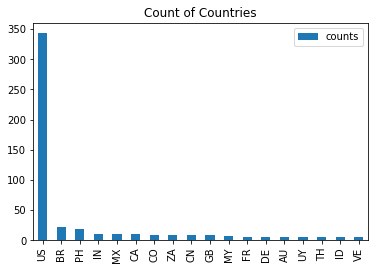

In [25]:
_ = country_count.plot.bar(title='Count of Countries')

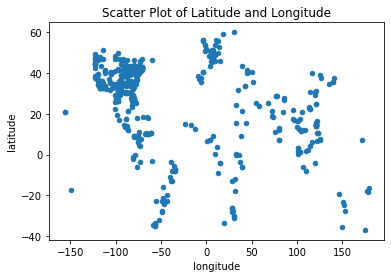

In [26]:
_ = df_file_check2.plot.scatter(
    x="longitude", y="latitude", title="Scatter Plot of Latitude and Longitude"
)

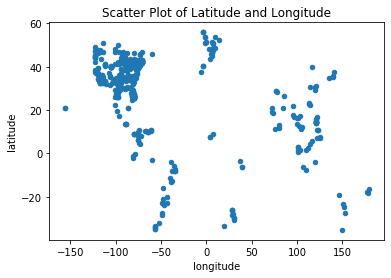

In [27]:
_ = df_file_check3.plot.scatter(
    x="longitude", y="latitude", title="Scatter Plot of Latitude and Longitude"
)

In [28]:
# final save
save_file_path1 = "data/headlinesGeoNamesAndLocationNoNaN.json"
df_file_check2.to_json(save_file_path1, orient = 'records')


In [29]:
df_file_check2.shape

(606, 5)

In [30]:
save_file_path2 = "data/headlinesGeoNamesAndLocationsNoNaNAbove2.json"
df_file_check3.to_json(save_file_path2, orient = 'records')


In [31]:
df_file_check3.shape

(533, 5)